# Landsat 7 ETM+ Land Surface Temperature and QA Masking

In [1]:
import os 
import yaml
from munch import munchify

# define repo name and get root working directory
repo = 'uhi'
root_path = os.getcwd()[ 0 : os.getcwd().find( repo ) + len ( repo )]

# get path to configuration files
cfg_path = os.path.join( root_path, 'cfg' )
cfg_path = os.path.join( cfg_path, 'landsat/etm' )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\uhi\\cfg\\landsat/etm'

### Retrieve Landsat 7 ETM+ Thermal Imagery via Sentinel-Hub Process API

In [2]:
# load cfg file using yaml parser
with open( os.path.join( cfg_path, 'process-lst.yml' ), 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )

In [3]:
# create instance of shclient class
from processapi import Client
client = Client( config, base_url = 'https://services-uswest2.sentinel-hub.com' )

In [4]:
# create aoi bounding box 
coords = -2.9, 51.2, -2.5, 51.5
bbox = client.getBoundingBox( coords )
resolution = 30

In [5]:
# arbitrary timeframe
from datetime import datetime
timeframe = { 'start' : datetime( 2021, 8, 1, 0, 0, 0 ), 
                'end' : datetime( 2021, 8, 30, 23, 59, 59 ) }

In [6]:
# get time series via process api
response = client.getTimeSeries ( bbox, timeframe, resolution=resolution )
response._df[ 'lst.tif' ]

0    [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
1    [[291.03925, 291.03925, 291.51093, 291.51093, ...
2    [[nan, nan, nan, nan, nan, nan, nan, nan, nan,...
3    [[280.14258, 280.32034, 280.32034, 280.02295, ...
Name: lst.tif, dtype: object

### Visualise Landsat 7 ETM+ RGB Images and QA Data Masks

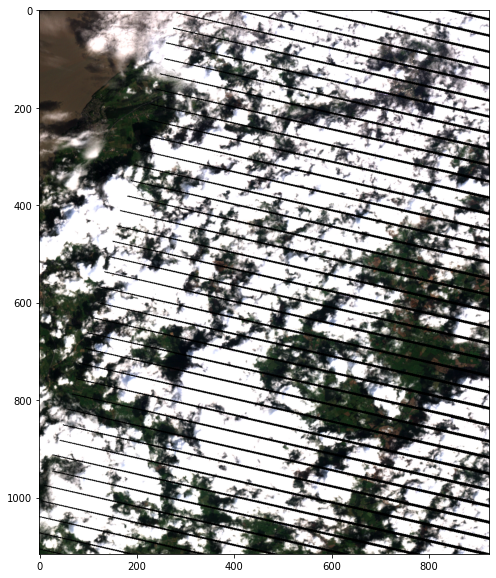

In [7]:
import matplotlib.pyplot as plt

# plot rgb image
ax = plt.figure( figsize=(10,10))
plt.imshow( response._df[ 'rgb.tif' ].iloc[ 1 ] ) 

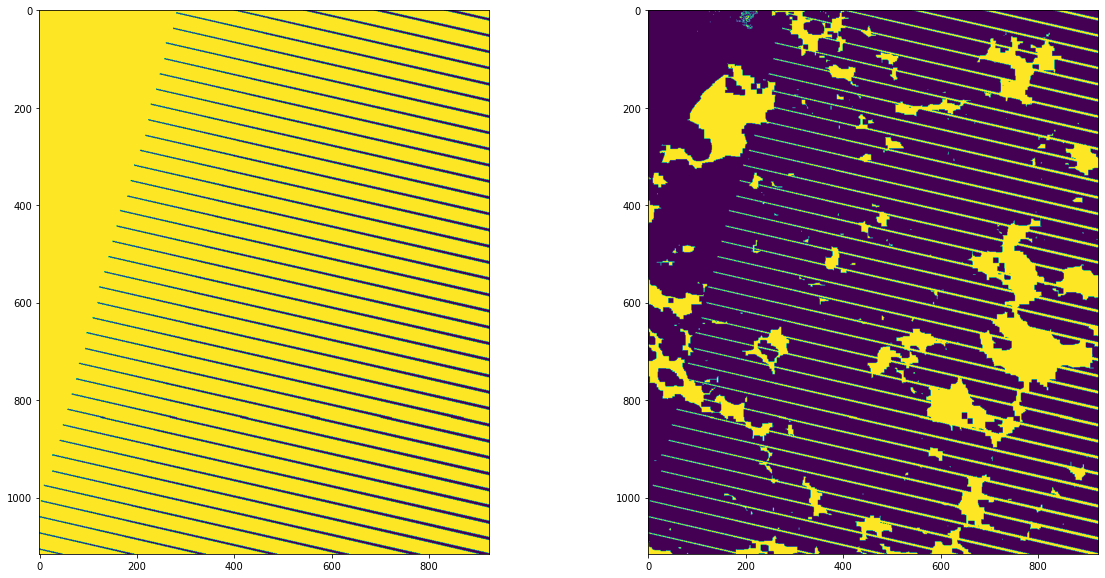

In [8]:
# plot data mask
_, axes = plt.subplots( figsize=(20,10), nrows=1, ncols=2)
axes[0].imshow( response._df[ 'data_mask.tif' ].iloc[ 1 ][ :, :, 0 ] )
axes[1].imshow( response._df[ 'data_mask.tif' ].iloc[ 1 ][ :, :, 1 ] < 2 ) 

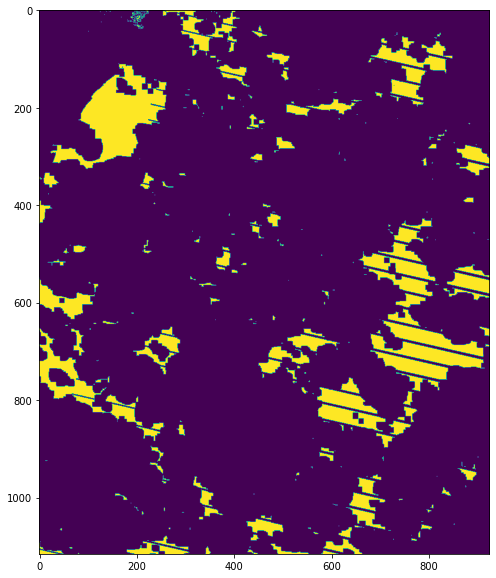

In [9]:
import matplotlib.pyplot as plt
ax = plt.figure( figsize=(10,10))

# plot combination of clear and inverted water qa bands
mask = response._df[ 'data_mask.tif' ].iloc[ 1 ][ :, :, 2 ]
plt.imshow( mask ) 

### Vectorize Clear + Non-water QA raster band to GeoDataFrame

In [10]:
import affine

# extract image geotransform
transform = affine.Affine.from_gdal( *response._transform )
transform

Affine(30.0, 0.0, 506986.74918956374,
       0.0, -30.0, 5705547.68212401)

In [11]:
import rasterio.features
import geopandas as gpd
from shapely.geometry import shape

# convert binary qa mask into georeferenced polygons
shapes = rasterio.features.shapes( mask.astype(int), mask=mask, transform=transform)
values = []; geometry = []

# build geodataframe with output
for feature, value in shapes:
    values.append(value)
    geometry.append(shape(feature))

# create geodataframe
polygons = gpd.GeoDataFrame(
    {'value': value, 'geometry': geometry }, crs="EPSG:{}".format( response._bbox.crs.value )
)

# add further attributes and apply size threshold
polygons[ 'area' ] = polygons[ 'geometry' ].area
polygons[ 'perimeter' ] = polygons[ 'geometry' ].length

polygons = polygons.sort_values( 'area', ascending=False )
polygons = polygons[ polygons[ 'area'] > 5 * 100 * 100 ]
polygons

,value,geometry,area,perimeter
184,1.0,"POLYGON ((511906.749 5702217.682, 512326.749 5...",17398800.0,46080.0
321,1.0,"POLYGON ((506986.749 5685987.682, 507016.749 5...",4987800.0,27360.0
301,1.0,"POLYGON ((527386.749 5685597.682, 527386.749 5...",4689900.0,19980.0
296,1.0,"POLYGON ((528076.749 5686437.682, 528076.749 5...",4148100.0,17520.0
308,1.0,"POLYGON ((527356.749 5684607.682, 527356.749 5...",3323700.0,13320.0
...,...,...,...,...
232,1.0,"POLYGON ((513436.749 5690847.682, 513466.749 5...",59400.0,1620.0
244,1.0,"POLYGON ((518836.749 5689557.682, 518836.749 5...",57600.0,1140.0
198,1.0,"POLYGON ((520756.749 5693637.682, 520756.749 5...",53100.0,1380.0
66,1.0,"POLYGON ((513076.749 5705217.682, 513106.749 5...",52200.0,2520.0


### Visualise QA Mask as a Collection of Georeferenced Polygons superimposed on OSM map

In [12]:
import folium

def plotMap( obj, color='orange' ):
    
    xmin, ymin, xmax, ymax = obj.geometry.total_bounds
    xc = xmin + ( ( xmax - xmin ) / 2 )
    yc = ymin + ( ( ymax - ymin ) / 2 )
    
    m = folium.Map(location=[ yc, xc ], zoom_start=10, tiles='CartoDB positron')

    for _, r in obj.iterrows():
        sim_geo = gpd.GeoSeries(r['geometry']).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(data=geo_j,
                               style_function=lambda x: {'color' : 'black', 'weight' : 1.0, 'fillColor': color} )
        geo_j.add_to(m)
    
    return m

In [13]:
plotMap( polygons.to_crs( 4326 ) )

### Compute 2003 Time Series of LST Statistics for Clear + Non-Water Georeferenced Polygons

In [14]:
# load cfg file using yaml parser
with open( os.path.join( cfg_path, 'statistical-lst.yml' ), 'r' ) as f:
    config = munchify( yaml.safe_load( f ) )
cfg_path

'C:\\Users\\crwil\\Documents\\GitHub\\uhi\\cfg\\landsat/etm'

In [15]:
# create instance of shclient class
from statisticalapi import Client
client = Client( config, base_url = 'https://services-uswest2.sentinel-hub.com'  )

In [16]:
import calendar
import pandas as pd
from datetime import datetime
import time

def getStatistics( year ):

    stats = list()
    for month in range( 2 ):
        
        # define one month timeframe
        _, last_day = calendar.monthrange( year, month + 1 )

        timeframe = { 'start' : datetime( year, month + 1, 1, 0, 0, 0 ), 
                        'end' : datetime( year, month + 1, last_day, 23, 59, 59 ) }
        
        print ( timeframe )

        # submit request and add to list
        response = client.getStatistics( [ timeframe ], resolution=500, polygons=polygons, interval='P1D' )
        stats.extend( response._dfs )
                
        time.sleep( 10 )
        
    return pd.concat( [ x for x in stats if not x.empty ] )

In [17]:
stats = getStatistics( 2003 )
stats

{'start': datetime.datetime(2003, 1, 1, 0, 0), 'end': datetime.datetime(2003, 1, 31, 23, 59, 59)}
{'start': datetime.datetime(2003, 2, 1, 0, 0), 'end': datetime.datetime(2003, 2, 28, 23, 59, 59)}


,id,interval_from,interval_to,stats_lst_min,stats_lst_max,stats_lst_mean,stats_lst_stDev,stats_lst_sampleCount,stats_lst_noDataCount,stats_lst_percentiles_33.0,stats_lst_percentiles_50.0,stats_lst_percentiles_75.0,stats_lst_percentiles_90.0
0,geom_20,2003-01-10,2003-01-11,265.445099,266.532043,266.192684,0.342878,8,1,266.125305,266.333801,266.439758,266.532043
0,geom_21,2003-01-10,2003-01-11,266.456848,269.177582,267.504807,0.876907,15,5,266.781555,267.598450,268.350433,269.177582
0,geom_26,2003-01-10,2003-01-11,264.115509,265.841583,264.978546,0.863037,10,8,265.841583,265.841583,265.841583,265.841583
0,geom_34,2003-01-10,2003-01-11,264.727325,266.453430,265.678900,0.601228,6,1,265.711700,265.711700,266.132141,266.453430
0,geom_90,2003-01-10,2003-01-11,265.472443,265.472443,265.472443,0.000000,1,0,265.472443,265.472443,265.472443,265.472443
...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,geom_123,2003-02-18,2003-02-19,274.400330,274.400330,274.400330,0.000000,1,0,274.400330,274.400330,274.400330,274.400330
0,geom_124,2003-02-18,2003-02-19,276.030701,276.030701,276.030701,0.000000,1,0,276.030701,276.030701,276.030701,276.030701
0,geom_125,2003-02-18,2003-02-19,276.673309,276.673309,276.673309,0.000000,1,0,276.673309,276.673309,276.673309,276.673309
0,geom_126,2003-02-18,2003-02-19,275.702576,275.702576,275.702576,0.000000,1,0,275.702576,275.702576,275.702576,275.702576


In [18]:
stats[ 'interval_from' ] = pd.to_datetime(stats[ 'interval_from' ])
stats[ 'interval_to' ] = pd.to_datetime(stats[ 'interval_to' ] )

stats[ 'stats_lst_dataCount' ] = stats[ 'stats_lst_sampleCount' ] - stats[ 'stats_lst_noDataCount' ]
stats

,id,interval_from,interval_to,stats_lst_min,stats_lst_max,stats_lst_mean,stats_lst_stDev,stats_lst_sampleCount,stats_lst_noDataCount,stats_lst_percentiles_33.0,stats_lst_percentiles_50.0,stats_lst_percentiles_75.0,stats_lst_percentiles_90.0,stats_lst_dataCount
0,geom_20,2003-01-10,2003-01-11,265.445099,266.532043,266.192684,0.342878,8,1,266.125305,266.333801,266.439758,266.532043,7
0,geom_21,2003-01-10,2003-01-11,266.456848,269.177582,267.504807,0.876907,15,5,266.781555,267.598450,268.350433,269.177582,10
0,geom_26,2003-01-10,2003-01-11,264.115509,265.841583,264.978546,0.863037,10,8,265.841583,265.841583,265.841583,265.841583,2
0,geom_34,2003-01-10,2003-01-11,264.727325,266.453430,265.678900,0.601228,6,1,265.711700,265.711700,266.132141,266.453430,5
0,geom_90,2003-01-10,2003-01-11,265.472443,265.472443,265.472443,0.000000,1,0,265.472443,265.472443,265.472443,265.472443,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,geom_123,2003-02-18,2003-02-19,274.400330,274.400330,274.400330,0.000000,1,0,274.400330,274.400330,274.400330,274.400330,1
0,geom_124,2003-02-18,2003-02-19,276.030701,276.030701,276.030701,0.000000,1,0,276.030701,276.030701,276.030701,276.030701,1
0,geom_125,2003-02-18,2003-02-19,276.673309,276.673309,276.673309,0.000000,1,0,276.673309,276.673309,276.673309,276.673309,1
0,geom_126,2003-02-18,2003-02-19,275.702576,275.702576,275.702576,0.000000,1,0,275.702576,275.702576,275.702576,275.702576,1


In [19]:
sum_stats = stats.groupby( 'interval_from' ).sum()
sum_stats = sum_stats [ [ 'stats_lst_sampleCount', 'stats_lst_dataCount' ] ]

sum_stats

,stats_lst_sampleCount,stats_lst_dataCount
interval_from,,
2003-01-10,41,26
2003-02-11,33,2
2003-02-18,1089,779


### Compute LST Mean weighted by Sample Count for all available dates 

In [20]:
records = []
for index in sum_stats.index:
    
    dataCount = sum_stats.loc[ index ][ 'stats_lst_dataCount' ]
    sampleCount = sum_stats.loc[ index ][ 'stats_lst_sampleCount' ]
    
    mean = 0.0; stdev = 0.0
    
    group = stats [ stats[ 'interval_from' ] == index ]
    for row in group.itertuples():     

        weight  = ( row.stats_lst_dataCount / dataCount )
        
        mean += row.stats_lst_mean * weight
        stdev += row.stats_lst_stDev * weight
    
    records.append( { 'date' : index , 
                      'mean' : mean,  
                      'stdev' : stdev, 
                      'dataCount' : dataCount, 
                      'percentCount' : ( dataCount / sampleCount ) * 100 } )

lst = pd.DataFrame( records )
lst

,date,mean,stdev,dataCount,percentCount
0,2003-01-10,266.424109,0.611593,26,63.414634
1,2003-02-11,275.735046,0.000000,2,6.060606
2,2003-02-18,275.922293,0.487478,779,71.533517
